In [1]:
%load_ext autoreload
%autoreload 2

import IPython
from pathlib import Path
import os
locals = IPython.extract_module_locals() # type: ignore
notebook_name = "/".join(locals[1]["__vsc_ipynb_file__"].split("/"))
os.chdir(Path(notebook_name).parent.parent)

In [2]:
from typing import Callable, Any
from pathlib import Path

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

seed = 0
random.seed(seed)
np.random.seed(seed)

In [3]:
relations = pl.read_parquet(".data/hm/intermediate/full/relations.parquet")
users = pl.read_parquet(".data/hm/intermediate/full/users.parquet")
items = pl.read_parquet(".data/hm/intermediate/full/articles.parquet")

In [4]:
n_users = relations.get_column("customer_id_map").n_unique()
n_items = items.get_column('article_id').n_unique()
relations_n_users = relations.get_column("customer_id").n_unique()
relations_n_items = relations.get_column("article_id").n_unique()

In [5]:
n_users

1362281

In [6]:
u_f = 0.01

relations_filtered = relations.join(relations.select("customer_id_map").unique().sample(fraction=u_f), on="customer_id_map", how="right")
relations_filtered_n_users = relations_filtered.get_column("customer_id").n_unique()
relations_filtered_n_items = relations_filtered.get_column("article_id").n_unique()

In [7]:
print(f"""(Users) Nunique: {n_users}
(Items) Nunique: {n_items}
(Relations, Users) Nunique: {relations_n_users} | diff: {n_users - relations_n_users}
(Relations, Items) Nunique: {relations_n_items} | diff: {n_items - relations_n_items}
(Relations, Users) Nunique (filtered): {relations_filtered_n_users} | diff: {n_users - relations_filtered_n_users}
(Relations, Items) Nunique (filtered): {relations_filtered_n_items} | diff: {n_items - relations_filtered_n_items}""")

(Users) Nunique: 1362281
(Items) Nunique: 105542
(Relations, Users) Nunique: 1362281 | diff: 0
(Relations, Items) Nunique: 104547 | diff: 995
(Relations, Users) Nunique (filtered): 13622 | diff: 1348659
(Relations, Items) Nunique (filtered): 52102 | diff: 53440


In [8]:
relations_filtered.shape

(317547, 7)

(array([2.577e+03, 9.740e+02, 1.430e+03, 5.490e+02, 9.410e+02, 3.640e+02,
        6.270e+02, 2.830e+02, 4.910e+02, 2.370e+02, 3.980e+02, 1.860e+02,
        3.200e+02, 1.400e+02, 2.880e+02, 1.370e+02, 2.540e+02, 1.180e+02,
        1.940e+02, 8.400e+01, 9.900e+01, 1.880e+02, 8.100e+01, 1.520e+02,
        8.600e+01, 1.450e+02, 6.200e+01, 1.300e+02, 6.400e+01, 1.310e+02,
        5.800e+01, 9.200e+01, 4.100e+01, 9.500e+01, 3.800e+01, 6.100e+01,
        4.400e+01, 7.500e+01, 3.100e+01, 6.600e+01, 3.300e+01, 2.700e+01,
        4.400e+01, 2.800e+01, 5.000e+01, 2.700e+01, 4.900e+01, 2.300e+01,
        3.500e+01, 2.200e+01, 4.100e+01, 2.300e+01, 3.800e+01, 1.600e+01,
        3.000e+01, 1.100e+01, 4.000e+01, 1.400e+01, 3.200e+01, 1.100e+01,
        3.200e+01, 1.300e+01, 1.600e+01, 2.800e+01, 1.900e+01, 1.900e+01,
        1.200e+01, 1.700e+01, 1.000e+01, 1.400e+01, 1.300e+01, 2.300e+01,
        6.000e+00, 8.000e+00, 7.000e+00, 1.800e+01, 9.000e+00, 1.600e+01,
        9.000e+00, 1.100e+01, 8.000e+0

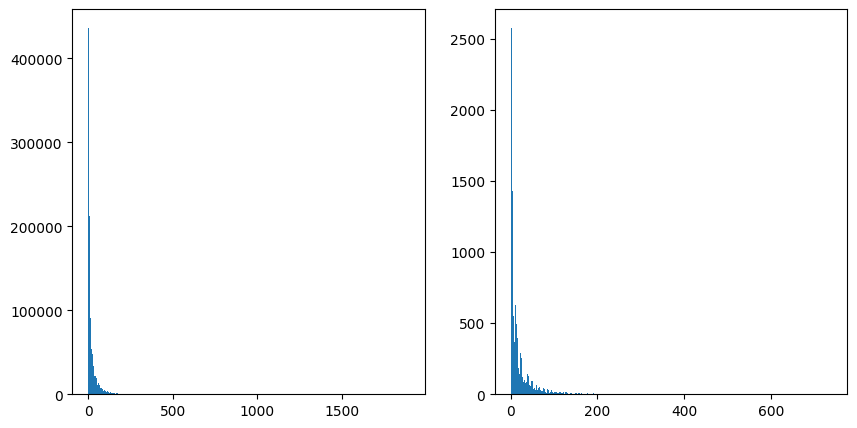

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

relations_cnt = relations.group_by("customer_id_map").agg(pl.len()).sort("len", descending=True)
relations_filtered_cnt = relations_filtered.group_by("customer_id_map").agg(pl.len()).sort("len", descending=True)
ax[0].hist(relations_cnt.select("len"), bins=500)
ax[1].hist(relations_filtered_cnt.select("len"), bins=500)

In [10]:
users_filtered = users.join(relations_filtered.select("customer_id").unique(), on="customer_id", how="inner").drop("customer_id_map")
items_filtered = items.join(relations_filtered.select("article_id").unique(), on="article_id", how="inner")

In [11]:
users_filtered = users_filtered.with_columns(customer_id_map=pl.col("customer_id").cast(pl.Categorical).to_physical())
items_filtered = items_filtered.with_columns(article_id_map=pl.col("article_id").cast(pl.String).cast(pl.Categorical).to_physical())

users_id_map = users_filtered.select("customer_id", "customer_id_map").unique()
articles_id_map = items_filtered.select("article_id", "article_id_map").unique()
for c, id_map in zip(["customer_id", "article_id"], [users_id_map, articles_id_map]):
    id_map.write_parquet(f".data/hm/intermediate/frac_0_01/{c}_map.parquet")

In [12]:
relations_filtered = relations_filtered.drop("customer_id_map", "article_id_map") \
    .sort("t_dat") \
    .join(users_id_map, on="customer_id", how="left") \
    .join(articles_id_map, on="article_id", how="left")

In [26]:
# Write files to parquet
users_filtered.write_parquet(".data/hm/intermediate/frac_0_01/users.parquet")
items_filtered.write_parquet(".data/hm/intermediate/frac_0_01/articles.parquet")
relations_filtered.write_parquet(".data/hm/intermediate/frac_0_01/relations.parquet")

In [13]:
relations_filtered

t_dat,customer_id,article_id,price,sales_channel_id,customer_id_map,article_id_map
date,str,i64,f64,i64,u32,u32
2018-09-20,"""dde33088d85fd56d202c48167252cf…",372860001,0.013542,1,11697,879
2018-09-20,"""dde33088d85fd56d202c48167252cf…",552227001,0.016949,1,11697,4720
2018-09-20,"""e63fa2967926bba93b95f06cccb275…",664133002,0.042356,2,12232,16671
2018-09-20,"""e63fa2967926bba93b95f06cccb275…",664133002,0.042356,2,12232,16671
2018-09-20,"""e63fa2967926bba93b95f06cccb275…",572998001,0.050831,2,12232,6763
…,…,…,…,…,…,…
2020-09-22,"""a6f6040fff6fe551602030a1addc48…",866455003,0.016932,1,8738,47689
2020-09-22,"""a6f6040fff6fe551602030a1addc48…",791587010,0.025407,1,8738,38215
2020-09-22,"""31a545f898a5a749801c4066e2c7bf…",587026035,0.050831,1,2563,7832


In [14]:
users_filtered

customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_map
str,f64,f64,str,str,i64,str,u32
"""0000757967448a6cb83efb3ea7a3fb…",null,null,"""ACTIVE""","""NONE""",20,"""fe7b8e2b3fafb89ca90db17ffeeae0…",0
"""0001f8cef6b9702d54abf66fd89eb2…",null,null,"""ACTIVE""","""NONE""",21,"""4211d6bf468de190b2f135feed96ed…",1
"""0002d2ef78ec29c03a951963a2694b…",null,null,"""ACTIVE""","""NONE""",48,"""9b9e1c0198670ed17ef23e4757eac8…",2
"""0002e6a17e3a75600888cac019846a…",1.0,1.0,"""ACTIVE""","""Regularly""",18,"""53c59467d0f76106835736898b2910…",3
"""0004ec078693c417c08ef6be811a09…",null,null,"""ACTIVE""","""NONE""",27,"""d19fa8de21671563e4e02611e7fe19…",4
…,…,…,…,…,…,…,…
"""fff09a52f77d13e758c08f7981cb6a…",null,null,"""ACTIVE""","""NONE""",21,"""17eb98db07c24e559449610f8a0a79…",13617
"""fff2be86ec6e8b738cb09b0bbb55d9…",null,null,"""ACTIVE""","""NONE""",31,"""26eb7cfaceefb3c3da59b85e230747…",13618
"""fff5300d1e80ad5dc05d180d953c35…",1.0,1.0,"""ACTIVE""","""Regularly""",59,"""0035640d00d7d24cd04eb74c0fd0fe…",13619


In [33]:
from sklearn.preprocessing import OneHotEncoder

categorical_columns = [
    "product_type_name", 
    "product_group_name", 
    "graphical_appearance_name", 
    "colour_group_name", 
    "perceived_colour_value_name", 
    "perceived_colour_master_name",
    "department_name",
    "index_name",
    "index_group_name",
    "section_name",
    "garment_group_name"
]

encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(items_filtered.select(categorical_columns).to_pandas())
encoded_df = pl.DataFrame(encoded_data.toarray(), schema=[f"{col}_{cat}" for col, cats in zip(categorical_columns, encoder.categories_) for cat in cats])
encoded_df

product_type_name_Alice band,product_type_name_Baby Bib,product_type_name_Backpack,product_type_name_Bag,product_type_name_Ballerinas,product_type_name_Beanie,product_type_name_Belt,product_type_name_Bikini top,product_type_name_Blanket,product_type_name_Blazer,product_type_name_Blouse,product_type_name_Bodysuit,product_type_name_Bootie,product_type_name_Boots,product_type_name_Bra,product_type_name_Bra extender,product_type_name_Bracelet,product_type_name_Braces,product_type_name_Bucket hat,product_type_name_Cap,product_type_name_Cap/peaked,product_type_name_Cardigan,product_type_name_Chem. cosmetics,product_type_name_Coat,product_type_name_Costumes,product_type_name_Cross-body bag,product_type_name_Dog Wear,product_type_name_Dog wear,product_type_name_Dress,product_type_name_Dungarees,product_type_name_Earring,product_type_name_Earrings,product_type_name_Felt hat,product_type_name_Fine cosmetics,product_type_name_Flat shoe,product_type_name_Flat shoes,product_type_name_Flip flop,…,section_name_Special Collections,section_name_Womens Big accessories,section_name_Womens Casual,section_name_Womens Everyday Basics,section_name_Womens Everyday Collection,section_name_Womens Jackets,section_name_Womens Lingerie,"section_name_Womens Nightwear, Socks & Tigh",section_name_Womens Premium,section_name_Womens Shoes,section_name_Womens Small accessories,"section_name_Womens Swimwear, beachwear",section_name_Womens Tailoring,section_name_Womens Trend,section_name_Young Boy,section_name_Young Girl,garment_group_name_Accessories,garment_group_name_Blouses,garment_group_name_Dressed,garment_group_name_Dresses Ladies,garment_group_name_Dresses/Skirts girls,garment_group_name_Jersey Basic,garment_group_name_Jersey Fancy,garment_group_name_Knitwear,garment_group_name_Outdoor,garment_group_name_Shirts,garment_group_name_Shoes,garment_group_name_Shorts,garment_group_name_Skirts,garment_group_name_Socks and Tights,garment_group_name_Special Offers,garment_group_name_Swimwear,garment_group_name_Trousers,garment_group_name_Trousers Denim,"garment_group_name_Under-, Nightwear",garment_group_name_Unknown,garment_group_name_Woven/Jersey/Knitted mix Baby
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,